In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [3]:
train_dir = '/Users/nirmal/Downloads/ECE1512_2022W_ProjectRepo_NirmalPol-main/Project A/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/Users/nirmal/Downloads/ECE1512_2022W_ProjectRepo_NirmalPol-main/Project A/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [4]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [7]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [8]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [9]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

<ipython-input-9-21ffe848dc4c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/150
140/140 [==============================] - 261s 2s/step - loss: 1.9177 - accuracy: 0.2431
Epoch 2/150
140/140 [==============================] - 251s 2s/step - loss: 1.5564 - accuracy: 0.3884
Epoch 3/150
140/140 [==============================] - 245s 2s/step - loss: 1.3181 - accuracy: 0.4638
Epoch 4/150
140/140 [==============================] - 244s 2s/step - loss: 1.2109 - accuracy: 0.5226
Epoch 5/150
140/140 [==============================] - 260s 2s/step - loss: 1.1651 - accuracy: 0.5347
Epoch 6/150
 18/140 [==>...........................] - ETA: 3:44 - loss: 1.1540 - accuracy: 0.5347

KeyboardInterrupt: 

In [ ]:
model.save('HMT.h5')

# Load Model and Evaluate

In [14]:
model=load_model('HMT.h5')

In [16]:
##Task3-Question 1
#Overall classification accuracy on the test set

loss, acc = model.evaluate(test_generator)

16/16 [==============================] - 7s 450ms/step - loss: 0.5554 - accuracy: 0.8347


In [50]:
##Task3-Question 1 
#Class-wise classification accuracy for all classes

#Divide predicted results with test results for each class.
correct_response = [0, 0, 0, 0, 0, 0, 0, 0]
y_pred = model.predict(test_generator)

y_true = test_generator.classes
for i in range(len(y_true)):
    if np.argmax(y_pred[i]) == y_true[i]:
        correct_response[y_true[i]] += 1

for i in range(8):
    print("Classification accuracy for {} is {}".format(list(test_generator.class_indices.keys())[i], 
                                                        correct_response[i]/np.count_nonzero(y_true == i)))

Classification accuracy for 01_TUMOR is 0.8548387096774194
Classification accuracy for 02_STROMA is 0.7580645161290323
Classification accuracy for 03_COMPLEX is 0.7741935483870968
Classification accuracy for 04_LYMPHO is 0.8548387096774194
Classification accuracy for 05_DEBRIS is 0.6612903225806451
Classification accuracy for 06_MUCOSA is 0.8225806451612904
Classification accuracy for 07_ADIPOSE is 0.9516129032258065
Classification accuracy for 08_EMPTY is 1.0


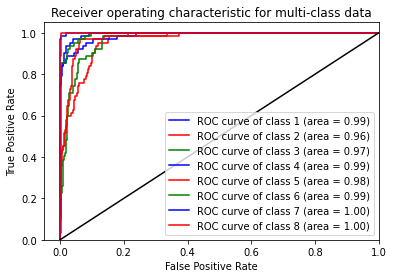

In [53]:
##Task3-Question 1
#Plot the classification ROC and AUC curves for each class
sample_row = [0, 0, 0, 0, 0, 0, 0, 0]
y_test_classes = np.array([])

for i in range(len(y_true)):
    if i==0:
        sample_row[y_true[i]] = 1
        y_test_classes = np.array([sample_row])
    else:
        sample_row[y_true[i]] = 1
        y_test_classes = np.vstack([y_test_classes, sample_row])
        
    sample_row = [0, 0, 0, 0, 0, 0, 0, 0]

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#The following charting code was obtained from 
#https://towardsdatascience.com/roc-curve-explained-using-a-covid-19-hypothetical-example-binary-multi-class-classification-bab188ea869c

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc


n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [54]:
##Task3-Question 1
#Plot the normalized confusion matrix
from sklearn.metrics import confusion_matrix

predictions = [0]*len(y_pred)
for i in range(len(y_pred)):
    predictions[i] = np.argmax(y_pred[i])
predictions = np.array(predictions)

matrix = confusion_matrix(y_true, predictions)
print(matrix)

[[53  0  7  1  0  1  0  0]
 [ 0 47  5  0  9  1  0  0]
 [ 0 10 48  2  2  0  0  0]
 [ 2  0  7 53  0  0  0  0]
 [ 0 20  0  0 41  1  0  0]
 [ 2  0  5  1  3 51  0  0]
 [ 0  0  0  0  0  0 59  3]
 [ 0  0  0  0  0  0  0 62]]


In [55]:
##Task3-Question 1

#Precision, Recall, and F-1 score on the test set

from sklearn.metrics import precision_score
precision = precision_score(y_true, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The precision on the test set is " + str(precision))

from sklearn.metrics import recall_score
recall = recall_score(y_true, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The recall on the test set is "+str(recall))

f_1 = (2 * precision * recall) / (precision + recall)
print("The F-1 score on the test set is "+str(f_1))

The precision on the test set is 0.8223234624145785
The recall on the test set is 0.8317972350230415
The F-1 score on the test set is 0.8270332187857962


# Explanation

In [211]:
from xai_utils import *
test_generator.reset()
image_batch,label_batch=test_generator.next()
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
index=8
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


## LIME (Local Interpretable Model-Agnostic Explanation)

In [241]:
from lime import lime_image
explain_model = lime_image.LimeImageExplainer()
explainer = explain_model.explain_instance(image_batch[31], model.predict, top_labels=2, hide_color=0, num_samples=100)

image, mask = explainer.get_image_and_mask(explainer.top_labels[0], positive_only=True, num_features=5, hide_rest=True)


  0%|          | 0/100 [00:00<?, ?it/s]

In [256]:
mask=mask.astype('float32')
mask -= mask.min()
mask /= mask.max()+10e-30
mask.shape

(224, 224)

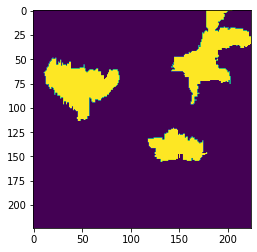

In [257]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

plt.imshow(mask)

## RISE (Randomized Input Sampling for Explanation)

In [190]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]), N_MASKS=200)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 14.9 s, sys: 2.56 s, total: 17.5 s
Wall time: 2.88 s


Text(0.5, 1.0, 'Explanation map (RISE)')

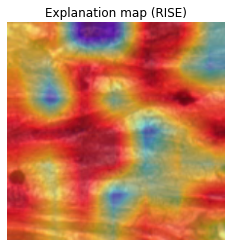

In [191]:
#@title Plot the results

plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [83]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

## Drop and Increase Rate with RISE

In [185]:
%%time
test_generator.reset()
drop_total_RISE = 0
increase_total_RISE = 0
for i in range(16):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    print("Working on batch ", str(i))
    
    for j in range(len(image_batch)):
        explanation_map_RISE = RISE(image_batch[j], model, class_index=np.argmax(prediction[index]),N_MASKS=100)
        explanation_map_RISE -= explanation_map_RISE.min()
        explanation_map_RISE /= explanation_map_RISE.max()+10e-30
        
        drop, increase, ori_pred, exp_pred = calculate_drop_increase(image_batch[j:j+1], model, explanation_map_RISE, 
                                class_index=np.argmax(prediction[index]), frac=0.9)
        drop_total_RISE+=drop
        increase_total_RISE+=increase
        #print("Original prediction is ",str(ori_pred), "Ex_prediction is ", str(exp_pred))

Working on batch  0
Working on batch  1
Working on batch  2
Working on batch  3
Working on batch  4
Working on batch  5
Working on batch  6
Working on batch  7
Working on batch  8
Working on batch  9
Working on batch  10
Working on batch  11
Working on batch  12
Working on batch  13
Working on batch  14
Working on batch  15
CPU times: user 1h 11min 45s, sys: 11min 56s, total: 1h 23min 41s
Wall time: 48min 16s


In [186]:
print(drop_total_RISE/(15*32))

print(increase_total_RISE/(15*32))

0.5849668411046379
0.17916666666666667


## Drop and Increase Rate with LIME

In [260]:
%%time

from lime import lime_image
test_generator.reset()

explain_model = lime_image.LimeImageExplainer()

drop_total_LIME = 0
increase_total_LIME = 0
for i in range(16):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    print("Working on batch ", str(i))
    
    for j in range(len(image_batch)):
        explainer = explain_model.explain_instance(image_batch[31], model.predict, 
                                           top_labels=2, hide_color=0, num_samples=100)

        image, mask = explainer.get_image_and_mask(explainer.top_labels[0], 
                                           positive_only=True, num_features=5, hide_rest=True)
        mask=mask.astype('float32')
        mask -= mask.min()
        mask /= mask.max()+10e-30

        drop, increase, ori_pred, exp_pred = calculate_drop_increase(image_batch[j:j+1], model, mask, 
                                class_index=np.argmax(prediction[index]), frac=0.9)
        drop_total_LIME+=drop
        increase_total_LIME+=increase
        #print("Original prediction is ",str(ori_pred), "Ex_prediction is ", str(exp_pred))

Working on batch  0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  6


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  10


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  11


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  12


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  13


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  14


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  15


IndexError: index 31 is out of bounds for axis 0 with size 16

In [261]:
print(drop_total_LIME/(15*32))

print(increase_total_LIME/(15*32))

0.9201993211986343
0.07708333333333334


In [267]:
layers = [['conv2d_3']]
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[1]

drop_rate /= (15*32)
increase_rate /= (15*32)

0
0
0
0
2
0
0
0
0
0
0
0
0
3
0
5
0
0
0
0
0
0
2
0
0
0
0
0
0
2
0
0
0
2
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
2
0
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
1
1
2
4
1
1
4
1
1
1
4
1
1
1
4
4
1
1
1
4
4
1
1
1
1
5
1
2
1
1
2
2
2
2
2
2
4
2
2
2
4
2
2
1
2
2
1
2
1
2
2
1
2
2
2
1
2
2
2
2
2
2
1
1
2
2
2
3
2
2
2
2
3
2
2
2
1
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
2
3
3
3
3
3
3
3
2
3
3
3
3
3
2
3
3
3
3
2
3
3
3
2
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
2
3
3
3
3
3
0
3
3
1
1
5
1
4
4
1
4
4
1
1
1
1
4
4
1
4
4
4
1
4
4
4
4
4
1
4
4
4
4
4
1
4
4
4
1
4
1
4
4
1
4
4
4
4
4
1
4
4
1
4
1
4
4
4
4
1
4
4
4
4
1
5
5
5
5
5
5
5
5
4
2
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
2
5
5
0
3
5
5
0
5
5
2
5
5
5
5
5
5
5
2
4
5
5
5
5
5
5
2
5
5
5
5
5
5
6
6
7
7
6
6
6
6
6
6
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [268]:
print(drop_rate)
print(increase_rate)

0.59773367667
0.17916666666666667
